In [13]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

In [14]:
data_dir = pathlib.Path('Data\VND_Banknotes_dataset')
RESULT            = pathlib.Path('Model\Result')
SAVED_MODEL       = pathlib.Path('Model\Saved Model')

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  shuffle=True,
  batch_size=32)

Found 3435 files belonging to 9 classes.
Using 2748 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  shuffle=False,
  batch_size=32)

Found 3435 files belonging to 9 classes.
Using 687 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['1000', '10000', '100000', '2000', '20000', '200000', '5000', '50000', '500000']


In [18]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)  # take the first 20% and save as test set
val_dataset = val_ds.skip(val_batches // 5) # skip (remove) that 20% out of validation set

In [21]:
all_image_paths = list(data_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths[0]

'Data\\VND_Banknotes_dataset\\1000\\079.jpg'

In [26]:
all_labels = list(map(lambda x: x.split('\\')[-2], all_image_paths))
all_labels[:10]

['1000',
 '1000',
 '1000',
 '1000',
 '1000',
 '1000',
 '1000',
 '1000',
 '1000',
 '1000']

In [27]:
label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir())
label_names

['1000',
 '10000',
 '100000',
 '2000',
 '20000',
 '200000',
 '5000',
 '50000',
 '500000']

In [28]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'1000': 0,
 '10000': 1,
 '100000': 2,
 '2000': 3,
 '20000': 4,
 '200000': 5,
 '5000': 6,
 '50000': 7,
 '500000': 8}

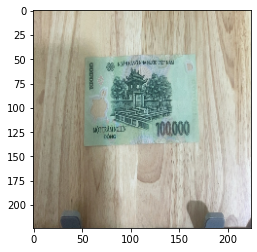

In [29]:
images, labels = next(iter(train_ds.take(1)))     # take 1 batch
sample_image = images[3]/255.0

plt.imshow(sample_image)    # accepted input: float [0..1] or int [0..255]

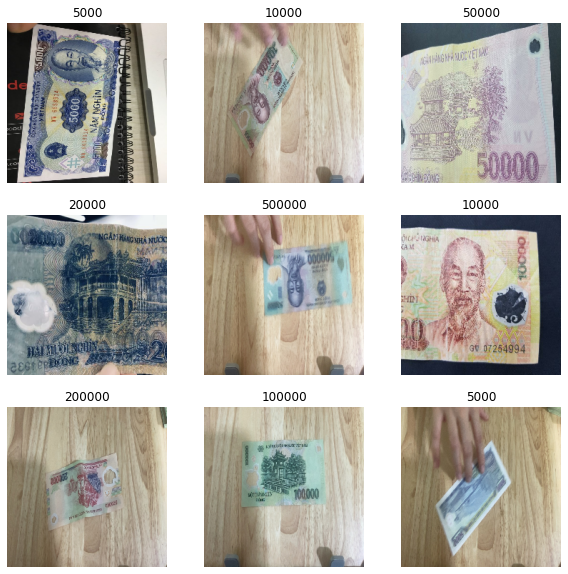

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]/255)   
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [31]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2,0.5)
])

In [33]:
# Add the sample image to a batch
sample_image = tf.expand_dims(sample_image, axis=0)  # 1,224,224,3

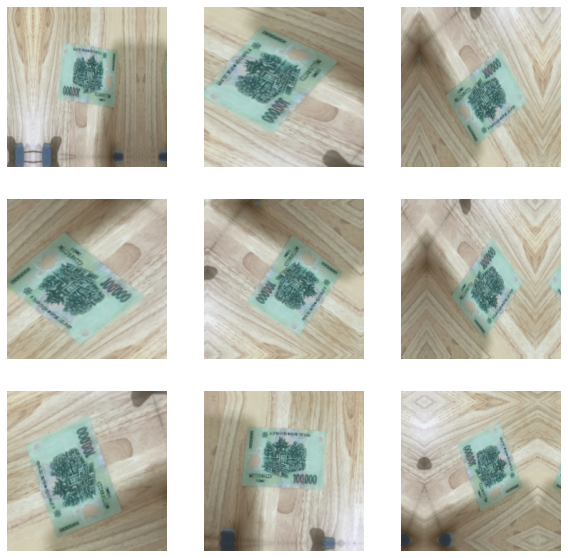

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(sample_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [35]:
from tensorflow import keras

In [36]:
base_model=keras.applications.Xception(
    weights='imagenet',
    include_top=False
)

In [37]:
# Freeze the base model
base_model.trainable = False

inputs = keras.Input(shape=(224,224,3))
x=data_augmentation(inputs)
x=keras.applications.xception.preprocess_input(x)
x=base_model(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
modelX=keras.Model(inputs,outputs)
modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [38]:
modelX.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint


In [40]:

callback = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4),
            ModelCheckpoint(monitor='val_loss', filepath=RESULT/'model_ckpt.h5', save_weights_only=False, save_best_only=True, verbose=1)]

In [41]:
init_epochs=10

history = modelX.fit(train_ds,
                    validation_data=val_dataset,
                    epochs=init_epochs,
                    callbacks = callback) 

Epoch 1/10
86/86 [==============================] - 65s 539ms/step - loss: 1.5198 - accuracy: 0.5167 - val_loss: 0.9114 - val_accuracy: 0.6977

Epoch 00001: val_loss improved from inf to 0.91141, saving model to Model\Result\model_ckpt.h5


C:\Users\congh\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
86/86 [==============================] - 42s 460ms/step - loss: 0.9550 - accuracy: 0.7231 - val_loss: 0.6961 - val_accuracy: 0.7352

Epoch 00002: val_loss improved from 0.91141 to 0.69605, saving model to Model\Result\model_ckpt.h5
Epoch 3/10
86/86 [==============================] - 41s 452ms/step - loss: 0.7804 - accuracy: 0.7824 - val_loss: 0.6213 - val_accuracy: 0.7746

Epoch 00003: val_loss improved from 0.69605 to 0.62134, saving model to Model\Result\model_ckpt.h5
Epoch 4/10
86/86 [==============================] - 32s 345ms/step - loss: 0.6834 - accuracy: 0.8068 - val_loss: 0.5497 - val_accuracy: 0.7889

Epoch 00004: val_loss improved from 0.62134 to 0.54973, saving model to Model\Result\model_ckpt.h5
Epoch 5/10
86/86 [==============================] - 27s 301ms/step - loss: 0.6071 - accuracy: 0.8253 - val_loss: 0.4642 - val_accuracy: 0.8229

Epoch 00005: val_loss improved from 0.54973 to 0.46416, saving model to Model\Result\model_ckpt.h5
Epoch 6/10
86/86 [==========

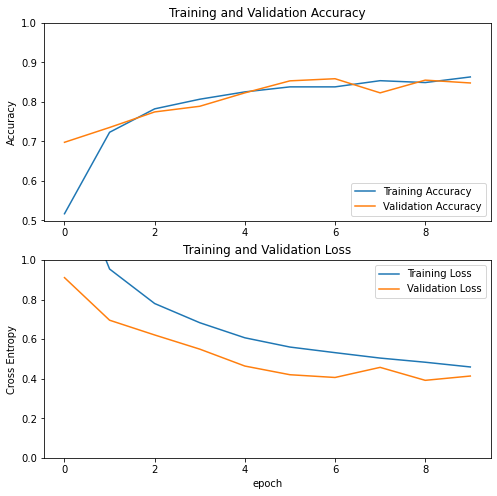

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [44]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [45]:
init_epochs = 10
fine_tune_epochs = 15
total_epochs = init_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds, 
                         validation_data=val_dataset,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callback)



Epoch 11/25
86/86 [==============================] - 34s 321ms/step - loss: 0.9766 - accuracy: 0.7580 - val_loss: 0.4929 - val_accuracy: 0.8140

Epoch 00011: val_loss did not improve from 0.39190
Epoch 12/25
86/86 [==============================] - 28s 313ms/step - loss: 0.7306 - accuracy: 0.8301 - val_loss: 0.5523 - val_accuracy: 0.7871

Epoch 00012: val_loss did not improve from 0.39190
Epoch 13/25
86/86 [==============================] - 28s 311ms/step - loss: 0.6140 - accuracy: 0.8475 - val_loss: 0.5502 - val_accuracy: 0.7871

Epoch 00013: val_loss did not improve from 0.39190
Epoch 14/25
86/86 [==============================] - 29s 328ms/step - loss: 0.4911 - accuracy: 0.8817 - val_loss: 0.4646 - val_accuracy: 0.7996

Epoch 00014: val_loss did not improve from 0.39190
Epoch 15/25
86/86 [==============================] - 34s 382ms/step - loss: 0.4371 - accuracy: 0.8890 - val_loss: 0.4076 - val_accuracy: 0.8265

Epoch 00015: val_loss did not improve from 0.39190
Epoch 16/25
86/86 [=

In [46]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

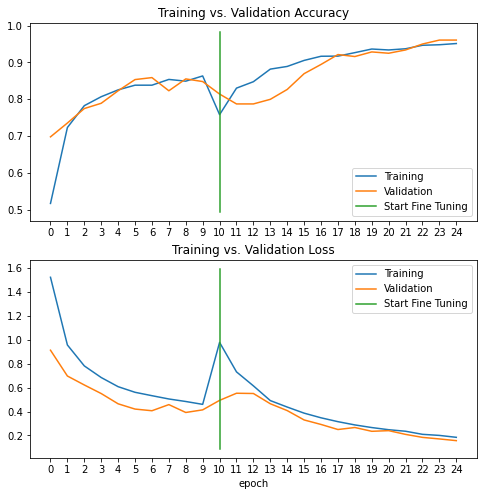

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [49]:
init_epochs = 25
fine_tune_epochs = 10
total_epochs = init_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds, 
                         validation_data=val_dataset,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callback)



Epoch 26/35
86/86 [==============================] - 41s 399ms/step - loss: 0.2144 - accuracy: 0.9425 - val_loss: 0.1499 - val_accuracy: 0.9571

Epoch 00026: val_loss improved from 0.15683 to 0.14989, saving model to Model\Result\model_ckpt.h5
Epoch 27/35
86/86 [==============================] - 31s 339ms/step - loss: 0.1881 - accuracy: 0.9476 - val_loss: 0.1647 - val_accuracy: 0.9499

Epoch 00027: val_loss did not improve from 0.14989
Epoch 28/35
86/86 [==============================] - 31s 347ms/step - loss: 0.1632 - accuracy: 0.9589 - val_loss: 0.1436 - val_accuracy: 0.9606

Epoch 00028: val_loss improved from 0.14989 to 0.14361, saving model to Model\Result\model_ckpt.h5
Epoch 29/35
86/86 [==============================] - 31s 346ms/step - loss: 0.1457 - accuracy: 0.9647 - val_loss: 0.1363 - val_accuracy: 0.9606

Epoch 00029: val_loss improved from 0.14361 to 0.13633, saving model to Model\Result\model_ckpt.h5
Epoch 30/35
86/86 [==============================] - 36s 408ms/step - lo

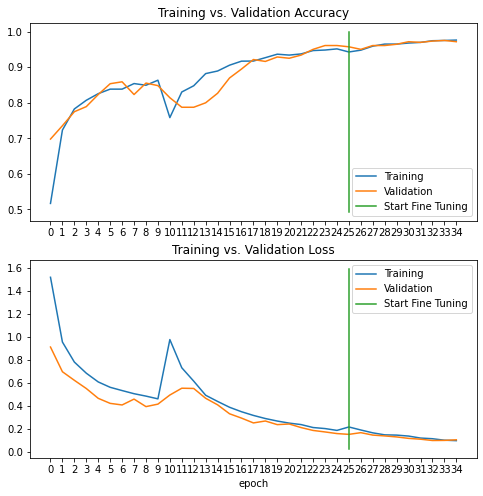

In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelX.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [52]:
init_epochs = 35
fine_tune_epochs = 10
total_epochs = init_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds, 
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=callback)



Epoch 36/45
86/86 [==============================] - 39s 385ms/step - loss: 0.1056 - accuracy: 0.9705 - val_loss: 0.0858 - val_accuracy: 0.9782

Epoch 00036: val_loss improved from 0.09637 to 0.08577, saving model to Model\Result\model_ckpt.h5
Epoch 37/45
86/86 [==============================] - 33s 374ms/step - loss: 0.0972 - accuracy: 0.9749 - val_loss: 0.0881 - val_accuracy: 0.9753

Epoch 00037: val_loss did not improve from 0.08577
Epoch 38/45
86/86 [==============================] - 37s 419ms/step - loss: 0.0953 - accuracy: 0.9753 - val_loss: 0.0904 - val_accuracy: 0.9694

Epoch 00038: val_loss did not improve from 0.08577
Epoch 39/45
86/86 [==============================] - 32s 361ms/step - loss: 0.0845 - accuracy: 0.9778 - val_loss: 0.0797 - val_accuracy: 0.9767

Epoch 00039: val_loss improved from 0.08577 to 0.07971, saving model to Model\Result\model_ckpt.h5
Epoch 40/45
86/86 [==============================] - 34s 374ms/step - loss: 0.0756 - accuracy: 0.9807 - val_loss: 0.0668

In [53]:
modelX.evaluate(val_dataset)

18/18 [==============================] - 7s 347ms/step - loss: 0.0611 - accuracy: 0.9857


[0.06106078624725342, 0.9856887459754944]

In [54]:
model_predict = keras.models.load_model('Model\Result\model_ckpt.h5')

In [55]:
modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # default 0.001
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\congh\AppData\Local\Temp/ipykernel_18772/23783473.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


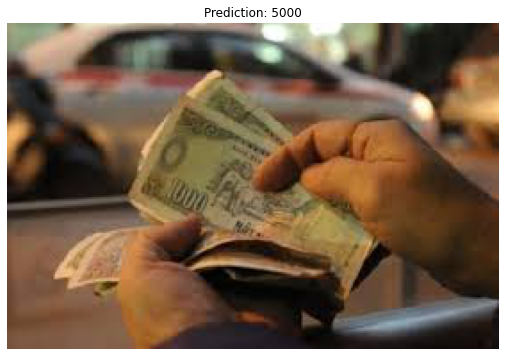

In [67]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg

def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model_predict.predict(img)

  for key, value in label_to_index.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

# TEST with your photo
image_path="Predict\zzzz.jpg"
predict(model_predict, image_path, 224)